**Picture Naming - bias analyses**

different plots for true vs. predicted scores
- predicted vs. actual score (gender two colors, country two colors)
- predicted vs. actual score with distributions; male, female, uk, us
- errors sorted from highest to lowest with demographic information

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from config.constants import GIT_DIRECTORY
from regression.plots import format_title

plt.rcParams["font.family"] = "Arial"
sns.set_theme(context="paper", style="white")

# setup
OOF_PATH = os.path.join(GIT_DIRECTORY, "results/regression/random_forest/oof_preds_all_scores.csv")

TARGET = "PictureNamingScore"
TASK   = "picnicScene"
MODEL  = "full"

gender_colors  = {"f": "tomato", "m": "royalblue"}
country_colors = {"uk": "tomato", "usa": "royalblue"}

oof = pd.read_csv(OOF_PATH)

if "Subject_ID" in oof.columns:
    oof = oof.rename(columns={"Subject_ID": "subject"})

required_cols = ["subject", "target", "model", "y_true", "y_pred", "task"]
for col in required_cols:
    if col not in oof.columns:
        raise KeyError(f"Column '{col}' missing in OOF file.")

sub = oof.loc[
    (oof["target"] == TARGET) &
    (oof["model"]  == MODEL)  &
    (oof["task"]   == TASK)
].copy()

sub["Gender"]  = sub["Gender_label"].astype(str).str.strip().str.lower()
sub["Country"] = sub["Country_label"].astype(str).str.strip().str.lower()

sub = sub[sub["Gender"].isin(["f", "m"]) & sub["Country"].isin(["uk", "usa"])]

In [2]:
# Compute errors
sub["error"] = sub["y_pred"] - sub["y_true"]
sub["abs_error"] = sub["error"].abs()

print("error overview:")
display(sub.sort_values("abs_error", ascending=False)[["subject", "y_true", "y_pred", "error", "Gender", "Country"]].head(10))

error overview:


,subject,y_true,y_pred,error,Gender,Country
4125,756,2.0,18.255029,16.255029,m,usa
4023,1348,3.0,18.464344,15.464344,f,uk
4735,994,6.0,17.578818,11.578818,f,uk
4619,197,6.0,17.101642,11.101642,f,uk
4345,952,7.0,17.188292,10.188292,m,usa
4231,186,8.0,17.771199,9.771199,f,usa
4786,1318,6.0,15.427316,9.427316,m,usa
4320,802,9.0,18.231159,9.231159,f,usa
4755,1113,8.0,16.166959,8.166959,f,usa
4642,344,10.0,18.042315,8.042315,f,uk


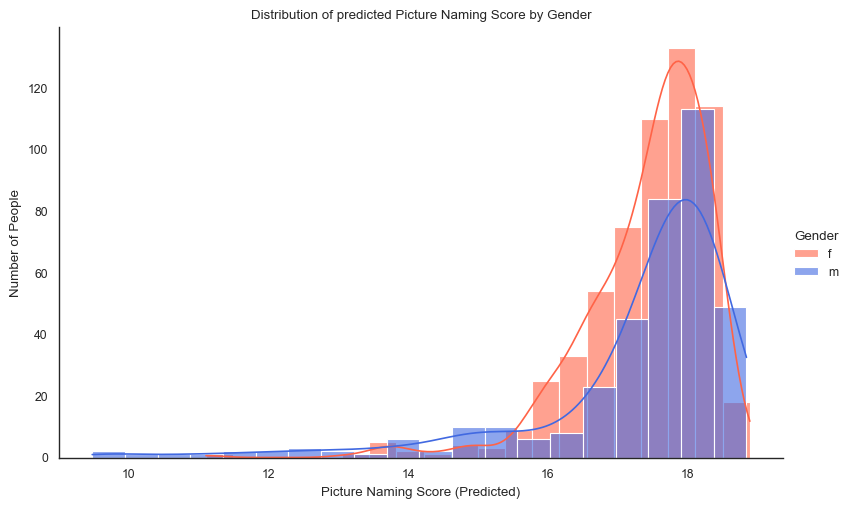

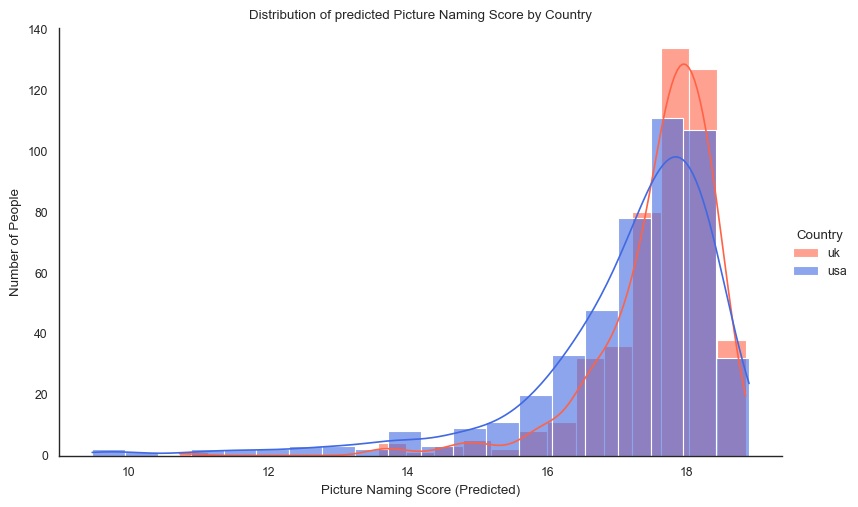

In [3]:
# predicted-score distributions
def plot_pred_distributions(df, group_col, palette, title_suffix):
    g = sns.FacetGrid(df, hue=group_col, palette=palette, height=5, aspect=1.6)
    g.map(sns.histplot, "y_pred", kde=True, bins=20, alpha=0.6)
    g.add_legend()
    g.set_axis_labels(f"{format_title(TARGET)} (Predicted)", "Number of People")
    plt.title(f"Distribution of predicted {format_title(TARGET)} by {title_suffix}")
    plt.show()

plot_pred_distributions(sub, "Gender",  gender_colors,  "Gender")
plot_pred_distributions(sub, "Country", country_colors, "Country")


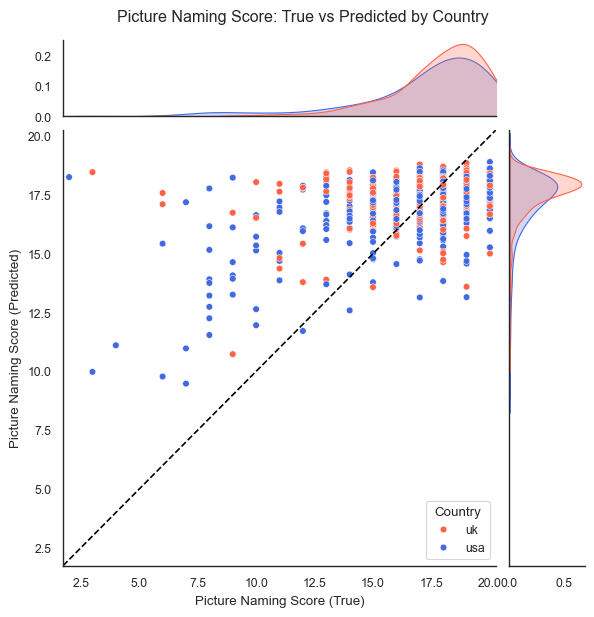

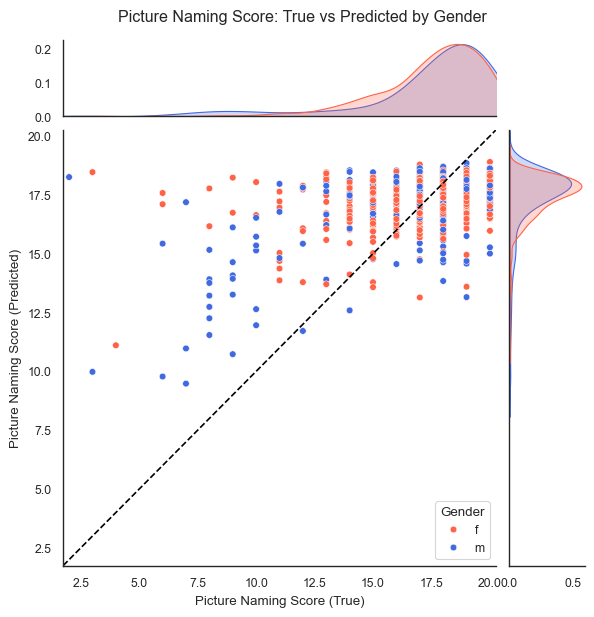

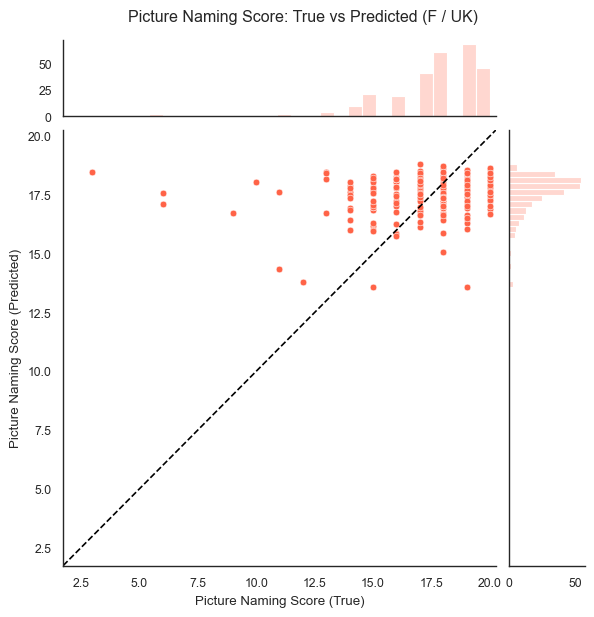

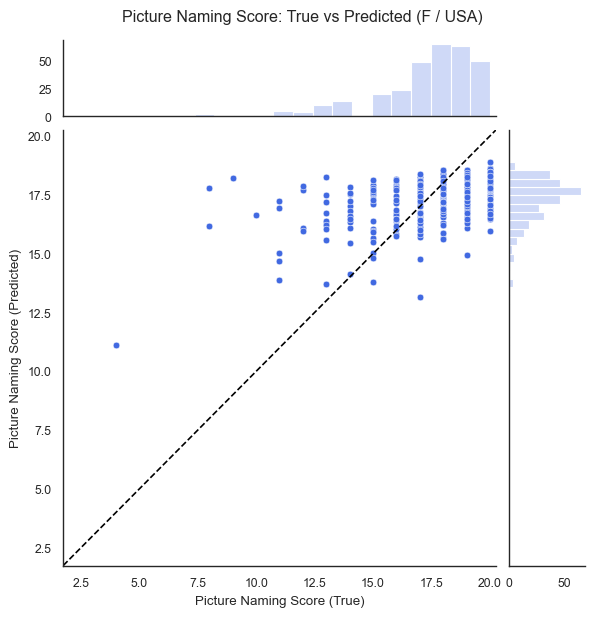

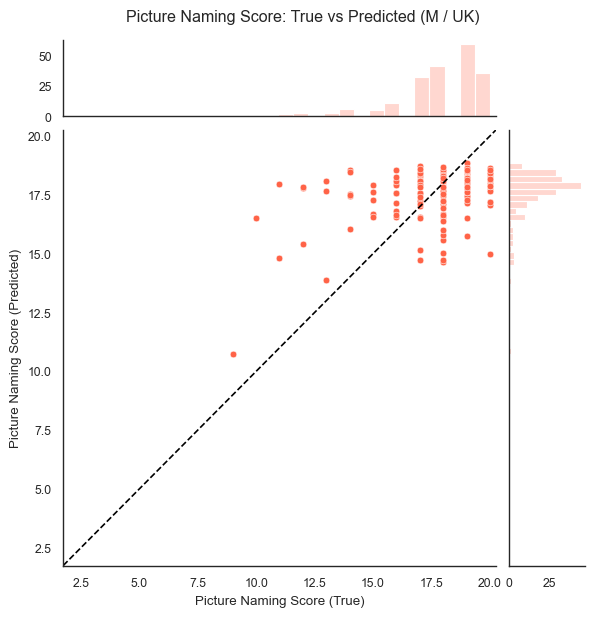

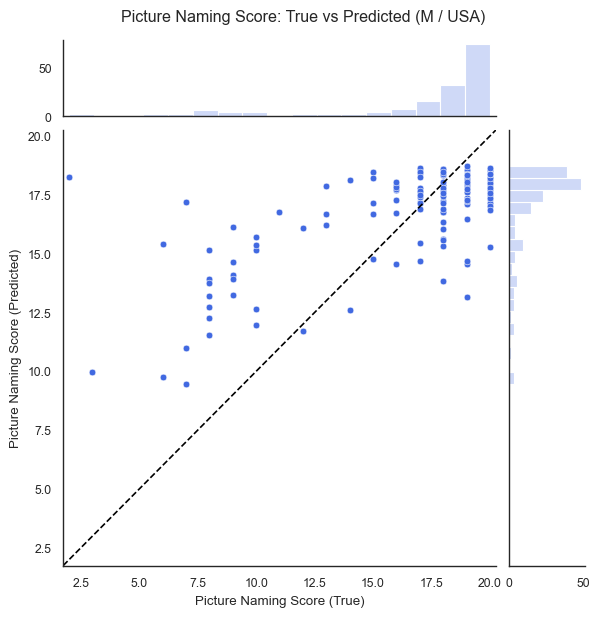

In [4]:
# True vs Predicted: plots
def compute_lims(df):
    pad = 0.25
    lo = np.nanmin([df["y_true"].min(), df["y_pred"].min()]) - pad
    hi = np.nanmax([df["y_true"].max(), df["y_pred"].max()]) + pad
    return lo, hi

lims = compute_lims(sub)

def joint_plot(df, hue=None, palette=None, color=None, title=None):
    if df.empty:
        print(f"[skip] {title} — empty subset")
        return

    if hue:
        g = sns.jointplot(
            data=df, x="y_true", y="y_pred", hue=hue, kind="scatter",
            height=6, space=0.18, palette=palette,
            marginal_ticks=True, marginal_kws=dict(fill=True, alpha=0.25, common_norm=False)
        )
    else:
        g = sns.jointplot(
            data=df, x="y_true", y="y_pred", kind="scatter",
            height=6, space=0.18, color=color,
            marginal_ticks=True, marginal_kws=dict(fill=True, alpha=0.25)
        )

    # identity line + limits
    g.ax_joint.plot([lims[0], lims[1]], [lims[0], lims[1]], ls="--", lw=1.2, color="black")
    g.ax_joint.set_xlim(lims); g.ax_joint.set_ylim(lims)
    g.set_axis_labels(f"{format_title(TARGET)} (True)", f"{format_title(TARGET)} (Predicted)")
    plt.suptitle(title, y=1.02)
    plt.show()

joint_plot(sub, "Country", country_colors, title=f"{format_title(TARGET)}: True vs Predicted by Country")
joint_plot(sub, "Gender", gender_colors, title=f"{format_title(TARGET)}: True vs Predicted by Gender")

for (g_val, c_val, clr) in [("f", "uk", "tomato"), ("f", "usa", "royalblue"), ("m", "uk", "tomato"), ("m", "usa", "royalblue")]:
    ss = sub[(sub["Gender"] == g_val) & (sub["Country"] == c_val)]
    joint_plot(ss, color=clr, title=f"{format_title(TARGET)}: True vs Predicted ({g_val.upper()} / {c_val.upper()})")


In [5]:
# summary of highest-error individuals
def summarize_top(df, label):
    n = len(df)
    row = {"bucket": label, "n": n}
    row.update({f"{col}_{val}_n": int(cnt) for col in ["Country", "Gender"]
                for val, cnt in df[col].value_counts().items()})
    row.update({f"{col}_{val}_pct": (df[col].eq(val).mean() if n > 0 else np.nan)
                for col in ["Country", "Gender"]
                for val in ["uk", "usa"] if col == "Country"
                or val in ["f", "m"] if col == "Gender"})
    return row

rows = [summarize_top(sub, "overall")]

for k in [10, 20, 50]:
    k = min(k, len(sub))
    rows.append(summarize_top(sub.nlargest(k, "abs_error"), f"top_{k}"))

for frac in [0.10, 0.20]:
    k = int(np.ceil(frac * len(sub)))
    rows.append(summarize_top(sub.nlargest(k, "abs_error"), f"top_{int(frac * 100)}pct"))

summary = pd.DataFrame(rows)

print("\nhighest-error group composition:")
display(summary)



highest-error group composition:


,bucket,n,Country_uk_n,Country_usa_n,Gender_f_n,Gender_m_n
0,overall,959,482,477,588,371
1,top_10,10,4,6,7,3
2,top_20,20,8,12,12,8
3,top_50,50,19,31,21,29
4,top_10pct,96,35,61,49,47
5,top_20pct,192,79,113,117,75


In [6]:
# group-wise predictive performance
def group_metrics(df, group_col):
    return (
        df.groupby(group_col)
        .apply(lambda x: pd.Series({
            "n": len(x),
            "mse": np.mean(np.square(x["error"])),
            "var": x["y_true"].var(ddof=1),
            "r²": 1 - np.mean(np.square(x["error"])) / x["y_true"].var(ddof=1),
            "rmse": np.sqrt(np.mean(np.square(x["error"]))),
            "mae": np.mean(np.abs(x["error"])),
        }))
        .reset_index()
    )

print("\nperformance metrics by country:")
display(group_metrics(sub, "Country"))

print("\nperformance metrics by gender:")
display(group_metrics(sub, "Gender"))


performance metrics by country:


/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_68723/1850227653.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,Country,n,mse,var,r²,rmse,mae
0,uk,482.0,4.635975,5.024064,0.077246,2.153131,1.553000
1,usa,477.0,6.258597,9.797403,0.361198,2.501719,1.811727



performance metrics by gender:


/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_68723/1850227653.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,Gender,n,mse,var,r²,rmse,mae
0,f,588.0,5.019094,5.828191,0.138825,2.240334,1.612251
1,m,371.0,6.114995,10.120420,0.395777,2.472852,1.791741
